In [1]:
%load_ext autoreload
%autoreload 2

from blochK import Hamiltonian2D
import blochK
from blochK.plotting import plot_FS, plot_bandstruc

import numpy as np
from numpy import pi,cos,sin,exp

import matplotlib.pyplot as plt
import matplotlib

from blochK.plotting.utils import extent #for getting the correct extent

# Defining the Haldane model

First, we define the Haldane model which consits of NN hoppings on the Honeycomb model, NNN imaginary hoppings and a sublattice potential.

In [2]:
n1 = np.array([ 0.5,np.sqrt(3)/2])
n2 = np.array([-0.5,np.sqrt(3)/2])

def Haldane_fct(kx,ky, t=1, t2=0, m=0, mu=0):
    """Defining the Haldane model."""
    Hk = np.zeros((2,2,*kx.shape), dtype=complex)

    kdotn1 = kx * n1[0] + ky * n1[1]
    kdotn2 = kx * n2[0] + ky * n2[1]
    f = 1 + np.exp(1j*kdotn1) + np.exp(1j*kdotn2)
    g = np.sin(kdotn1) - np.sin(kdotn2) + np.sin(kdotn2 - kdotn1)
    # NNN vectors (same-sublattice)
    b1 = n1 - n2
    b2 = -n1
    b3 = -n2
    kdotb1 = kx * b1[0] + ky * b1[1]
    kdotb2 = kx * b2[0] + ky * b2[1]
    kdotb3 = kx * b3[0] + ky * b3[1]
    dz0 = - mu
    dz  = m + 2.0 * t2 * (np.sin(kdotb1) + np.sin(kdotb2) + np.sin(kdotb3))


    Hk[0,0] = dz0 + dz
    Hk[1,1] = dz0 - dz
    Hk[0,1] = -t * f
    Hk = blochK.hamiltonian_fct.make_hermitian(Hk)
    
    return Hk

Haldane = Hamiltonian2D(Haldane_fct, n1=n1, n2=n2, basis=['sublattice'],basis_states=['A','B'])
Haldane.add_operator('sublattice',np.array([1,-1]))

Haldane.BZ.set_points({
    'K':  (Haldane.BZ.m1 + 2*Haldane.BZ.m2)/3,
    "K'": (2*Haldane.BZ.m1 + Haldane.BZ.m2)/3
})

The Bandstructure shows two inequivalent valleys.

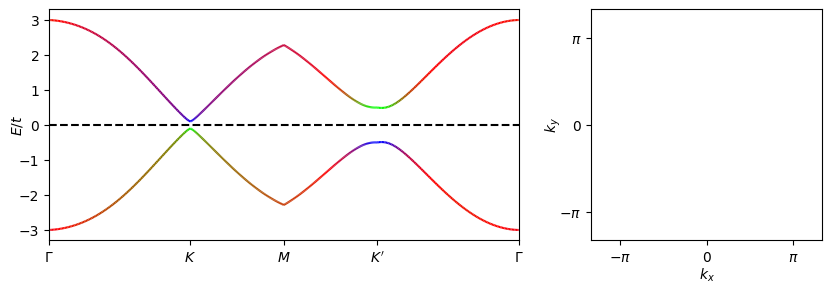

In [8]:
#Haldane model is topological for |t2|>sqrt(3)*m
Haldane.update_params(dict(t2=0.2/(3**0.5)*1.5,m=0.2,mu=0))

fig, [ax,ax1] = plt.subplots(1,2,gridspec_kw={'width_ratios': [2,1]},figsize=(10,3))
labels = ['\Gamma',"K",'M',"K'",'\Gamma']
coloring_operator = Haldane.operator.sublattice

plot_bandstruc(ax,Haldane,labels_points_path=labels,coloring_operator=coloring_operator)
plot_FS(ax1,Haldane,coloring_operator=coloring_operator,kmesh='BZ')

## Computing topological quantities

The Berry curvature

$\Omega_{n; xy}(\vec{k}) = \mathrm{i} \left[ \left\langle \frac{\partial u_{n}}{\partial k_x}| \frac{\partial u_{n}}{\partial k_y} \right\rangle - \left\langle \frac{\partial u_{n}}{\partial k_y} \middle| \frac{\partial u_{n}}{\partial k_x} \right\rangle\right]$

Here it is evaluated using the Fukui–Hatsugai–Suzuki method, i.e. a numerically stable version where the flux through small plaquettes of the Brillouin zone is computed. 

In [9]:
import blochK.topology

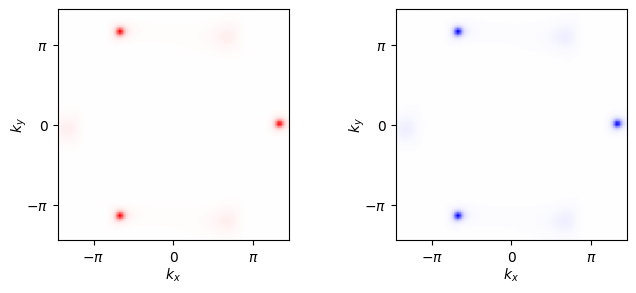

In [10]:
Lk = 101
ks = np.meshgrid(np.linspace(-4.6,4.6,Lk),np.linspace(-4.6,4.6,Lk),indexing='ij')
ks = np.array(ks)

#Berry curvature function returns the curvature and the kmesh which is trimmed of its edges
# If no kmesh is provided, it uses a the BZ of the Hamiltonian and the edges are not trimmed
berry_curvature,ks = blochK.topology.berry_curvature(Haldane,kmesh=ks) #shape=(nbands,Lk-2,Lk-2)


fig, axs = plt.subplots(1,2,figsize=(8,3))
vmax = np.max(np.abs(berry_curvature))
axs[0].imshow(berry_curvature[0].T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)
axs[1].imshow(berry_curvature[1].T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel(r'$k_x$',labelpad=1)
    ax.set_xticks([-pi,0,pi])
    ax.set_xticklabels([r'$-\pi$',0,r'$\pi$'])
    ax.set_ylabel(r'$k_y$',labelpad=-2.5)
    ax.set_yticks([-pi,0,pi])
    ax.set_yticklabels([r'$-\pi$',0,r'$\pi$'])
    ax.set_xticks([-pi,0,pi])
    ax.set_yticks([-pi,0,pi])

The Chern number 

$C_n = \frac{1}{2\pi} \sum_{\vec{k}}  \Omega_{n; xy}(\vec{k})$

calls the method 'berry_curvature' internally with a k-mesh which is automatically the BZ. It requires a gap between the bands.

In [11]:
blochK.topology.chern_number(Haldane)

array([ 1., -1.])

## Anomalous Hall conductivity

The anomalous Hall conductivity is set by the Berry curvature below the Fermi energy

$\sigma_{xy} = \frac{e^2}{\hbar} \frac{1}{2\pi} \sum_{\vec{k}} n_F(\epsilon(\vec{k}))  \Omega_{n; xy}(\vec{k})$

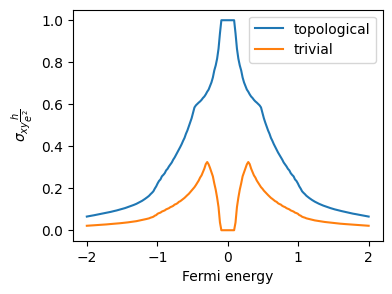

In [13]:
Lk = 100
energies = np.linspace(-2,2,200)

Haldane.update_params(dict(t2=0.2/(3**0.5)*1.5,m=0.2))
cond_topo = blochK.topology.conductivity_anomalous_Hall(Haldane,energy=energies,Lk=Lk)

Haldane.update_params(dict(t2=0.2/(3**0.5)*0.5,m=0.2))
cond_trivial = blochK.topology.conductivity_anomalous_Hall(Haldane,energy=energies,Lk=Lk)


fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(energies,cond_topo,label='topological')
ax.plot(energies,cond_trivial,label='trivial')

ax.set_xlabel('Fermi energy')
ax.set_ylabel(r'$\sigma_{xy} \frac{h}{e^2}$')
ax.legend()

In the topological phase the summed Berry curvature continously increases until it sums to 1, the Chern number of the lower band, when the Fermi energy is inside the gap. Inside the trivial phase inversion symmetry can also be broken ($K$ and $K'$ are not equivalent) such that at a given energy $\sigma_{xy} > 0$, because the Berry curvatures which compensate sit at different energies

## Mulitband Berry curvature

This is the multiband formulation of the Berry curvature, the so called non-Abelian Berry curvature the alogorithm implements the concept of *Sawahata et al. PRB 107, 024404 (2023)* which is a variation of the Suzuki-Fukui-Hatsugai method for the non Abelian Berry curvature.

Project to the subspace of bands at least partially below the Fermi level. (optional)

Compute the overlap
\begin{equation}
M_{mn}(\vec{k}, \vec{k}+\delta\vec{k}) = \langle u_m(\vec{k}) | u_n(\vec{k}+\delta\vec{k}) \rangle
\end{equation}

From this compute the link variable of the lowest $\alpha$ bands
\begin{equation}
U_\alpha(\vec{k},\delta\vec{k}) = \det_{n,m<=\alpha} M (\vec{k}, \vec{k}+\delta\vec{k})
\end{equation}

Compute the Berry curvature $F^\alpha$ of each occupation sector $\alpha$
\begin{equation}
F^\alpha = \mathrm{arg}\left[ U_\alpha(\vec{k},\delta \vec{k}_x) U_\alpha(\vec{k}+\delta \vec{k}_x,\delta \vec{k}_y) U^*_\alpha(\vec{k}+\delta \vec{k}_y,\delta \vec{k}_x) U^*_\alpha(\vec{k},\delta \vec{k}_y)\right]
\end{equation}

For each plaquette approximate the effective Berry curvature by the mean of the Berry fluxes of the occupation $\alpha_i$ at the corners
\begin{equation}
F = (F_{\alpha_1} + F_{\alpha_2} + F_{\alpha_3} + F_{\alpha_4})/4
\end{equation}

In [ ]:
Lk = 113
ks = np.meshgrid(np.linspace(-4.6,4.6,Lk),np.linspace(-4.6,4.6,Lk),indexing='ij')
ks = np.meshgrid(np.linspace(-4.6,4.6,Lk),np.linspace(-4.6,4.6,Lk+4),indexing='ij')
ks = Haldane.BZ.sample(Lk)

ks = np.array(ks)

es,psis = Haldane.diagonalize(*ks)

from blochK.topology.utils import partial_slogdets


def berry_curvature_multiband_state(es,psis,energy=0,project_bands=True):
    """The total non-Abelian Berry curvature below a given energy of a multiband systems. 
    ----------
    Parameters:
    es: ndarray, shape=(n_bands,Lkx,Lky)
        energys returned from Hamiltonian2D.diagonalize
    psis: array-like, shape (n_bands,Lkx,Lky,n_orbital)
        wavefunction returned from Hamiltonian2D.diagonalize
    energy: float or ndarray
        energy below which the effective total Berry curvature is computed
    project_bands:
        if True the bands are projected to a the subspace where they occupied. Becomes relevant for system with large number of bands above the maximal energy. 
    ----------
    Returns:
        flux : array-like, shape (energy,Lkx,Lky) or (Lkx,Lky)
    """

    #Check if input is correct, make energy an array
    if isinstance(energy,float) or isinstance(energy,int):
        max_energy = energy
        energy = np.array([energy])
    else:
        assert isinstance(energy,np.ndarray), "Energy must be a float,int or a ndarray"
        max_energy = energy.max()

    # project to fewer bands to reduce complexity
    if project_bands:
        occupied_bands = es.min(axis=(1,2))<max_energy
        psis = psis[occupied_bands] #shape = (n_occ,Lkx,Lky,n_orbital)
        es = es[occupied_bands]

    #M(k,dk)_mn = <u_m(kx,ky)|u_n(kx+dkx,ky)> 
    Mdx_xymn = np.einsum('mxyi,nxyi->xymn',psis,np.roll(np.conjugate(psis),1,axis=1))
    Mdy_xymn = np.einsum('mxyi,nxyi->xymn',psis,np.roll(np.conjugate(psis),1,axis=2))

    #Compute determinant of submatrix
    #Udx_xyo = ( det(Mdx_xymn m,n<1), det(Mdx_xymn m,n<2), det(Mdx_xymn m,n<3), ...)
    Udx_xyo = partial_slogdets(Mdx_xymn) 
    Udy_xyo = partial_slogdets(Mdy_xymn) 

    # Flux through plaqeuttes taking into account o bands
    # Udx_o(k) * Udy_o(k+dkx) * Udx_o(k+dky)^* * Udy_o(k)^*
    exp_of_flux_o = Udx_xyo * np.roll(Udy_xyo,1,axis=0) * np.conjugate(np.roll(Udx_xyo,1,axis=1)) * np.conjugate(Udy_xyo) 
    flux_xyo = np.angle(exp_of_flux_o)/4

    #select the flux with the right band multiplicity
    flux_xyo = np.insert(flux_xyo,0,np.zeros_like(flux_xyo[:,:,0]),axis=-1) # add a zero flux layer for the unoccupied bands

    flux_iexy = []
    for es_corners in [es, np.roll(es,-1,axis=1), np.roll(es,-1,axis=2), np.roll(np.roll(es,-1,axis=2),-1,axis=1)]:
        plaqutte_multiplicity_exy = (es_corners[None] < energy[:,None,None,None]).sum(axis=1) #number of occupied bands at each k-point
        #broadcast to the fluxes in different occupation sectors
        n_energys, Lx, Ly = plaqutte_multiplicity_exy.shape
        n_idx, m_idx = np.indices((Lx, Ly))
        n_idx = np.broadcast_to(n_idx, (n_energys, Lx, Ly))
        m_idx = np.broadcast_to(m_idx, (n_energys, Lx, Ly))
        e_idx = np.arange(n_energys)[:, None, None]
        flux_iexy.append(flux_xyo[n_idx, m_idx, plaqutte_multiplicity_exy])
    flux_exy = np.mean(flux_iexy,axis=0)

    if flux_exy.shape[0]==1:
        return flux_exy[0]
    else:
        return flux_exy
    

berry_curvature2 = berry_curvature_multiband_state(es,psis)



berry_curvature = blochK.topology.utils.berry_curvature_state(psis)
w_berry_curv = np.sum(berry_curvature*(es<0),axis=0)



print(berry_curvature.shape,berry_curvature2.shape)

#update the k-mesh.



(2, 113, 113) (113, 113)


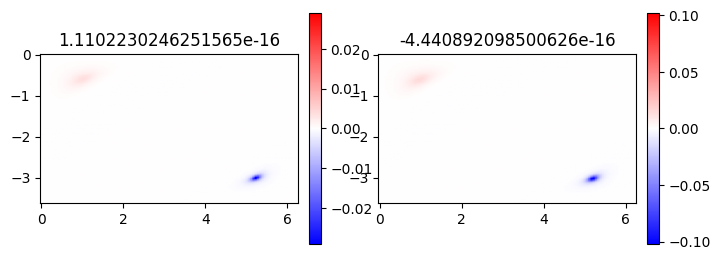

In [26]:
fig, axs = plt.subplots(1,2,figsize=(8,3))


axs[0].set_title(berry_curvature2.sum())
vmax = np.max(np.abs(berry_curvature2))
im = axs[0].imshow(berry_curvature2.T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)
plt.colorbar(im,ax=axs[0],fraction=0.046,pad=0.04)

axs[1].set_title(w_berry_curv.sum())
vmax = np.max(np.abs(w_berry_curv))
im = axs[1].imshow(w_berry_curv.T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)
plt.colorbar(im,ax=axs[1],fraction=0.046,pad=0.04)

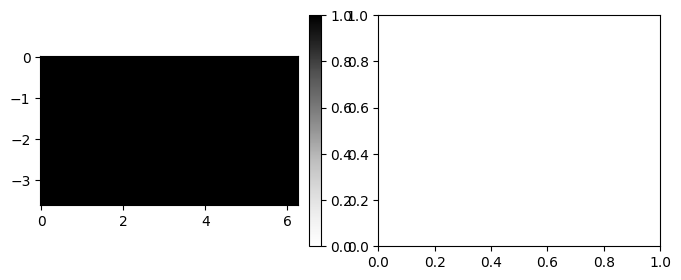

In [65]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
vmax = 0.5
im = axs[0].imshow((es<0)[0,1:-1,1:-1].T,extent=extent(ks),origin='lower',cmap='Greys',vmin=0,vmax=1)
plt.colorbar(im,ax=axs[0],fraction=0.046,pad=0.04)




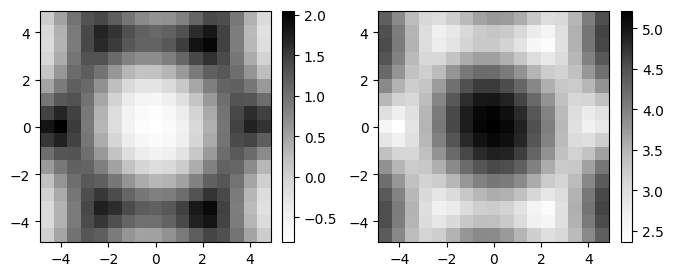

In [200]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
vmax = 0.5
im = axs[0].imshow(es[0].T,extent=extent(ks),origin='lower',cmap='Greys')
plt.colorbar(im,ax=axs[0],fraction=0.046,pad=0.04)

im = axs[1].imshow(es[1].T,extent=extent(ks),origin='lower',cmap='Greys')
plt.colorbar(im,ax=axs[1],fraction=0.046,pad=0.04)


In [73]:
occ = es[None] < np.array([-1,0,1])[:,None,None,None]

occ.shape



(3, 2, 113, 113)

In [10]:
np.roll(np.arange(10),1)

array([9, 0, 1, 2, 3, 4, 5, 6, 7, 8])